In [1]:
# !pip install -r requirements.txt
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=9f1f601eea7c61f56933ecfbdbabfb974465befa993907beec01e279af53da9e
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# 0. 라이브러리

# 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle
import random

In [3]:

seed_num = 42
tf.random.set_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data load
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)


In [6]:
overall = train_set.shape[0] + valid_set.shape[0] + test_set.shape[0]
print('train:validation:test = %.4f:%.4f:%.4f'%((train_set.shape[0] / overall), (valid_set.shape[0] / overall), (test_set.shape[0] / overall)))

train:validation:test = 0.7000:0.1000:0.2000


In [7]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

In [8]:
train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

,userID,movieID,rating,compound,senti_score,NeMFRating,SBMFRating,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
1633870,143756,31800,1.00,0.5719,3,3,4,0.00,0.00,0.00,0.00,16.67,0.00,0.00,33.33,0.00,16.67
3115182,272600,13746,1.00,0.0000,2,3,3,0.00,11.11,0.00,11.11,0.00,0.00,0.00,11.11,0.00,0.00
2383131,208589,23849,0.50,-0.2023,1,2,3,10.53,5.26,5.26,5.26,0.00,5.26,5.26,5.26,10.53,10.53
2079042,182422,14736,0.75,0.9666,3,3,5,5.04,4.20,9.24,8.40,6.72,7.56,5.04,4.20,14.29,13.45
651398,56973,53386,1.00,0.9260,3,3,5,0.00,27.27,0.00,4.55,18.18,0.00,13.64,40.91,0.00,27.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158490,13844,27705,1.00,0.7351,3,3,4,0.00,0.00,0.00,0.00,8.00,0.00,0.00,20.00,0.00,12.00
1734117,152410,28106,0.75,0.8750,3,3,5,0.00,3.77,0.00,3.77,3.77,0.00,3.77,11.32,3.77,5.66
1564450,137584,43164,1.00,0.6249,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33.33
212205,18521,42215,1.00,0.4588,3,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# 3.Model

In [9]:
def conv_block(n_layers, latent_dims, names):
    ModuleList = []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [10]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, GMF])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1)))//2, 'UserItemNeuMF'):

        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [11]:
user_num = 281335
item_num = 59044

id_dims = 128# each 32 dims
total_layer_dims = 32 # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16

In [12]:
model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 UserInput (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 ItemInput (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 UserIDEmb (Embedding)          (None, 1, 128)       36010880    ['UserInput[0][0]']              
                                                                                                  
 ItemIDEmb (Embedding)          (None, 1, 128)       7557632     ['ItemInput[0][0]']              
                                                                                              

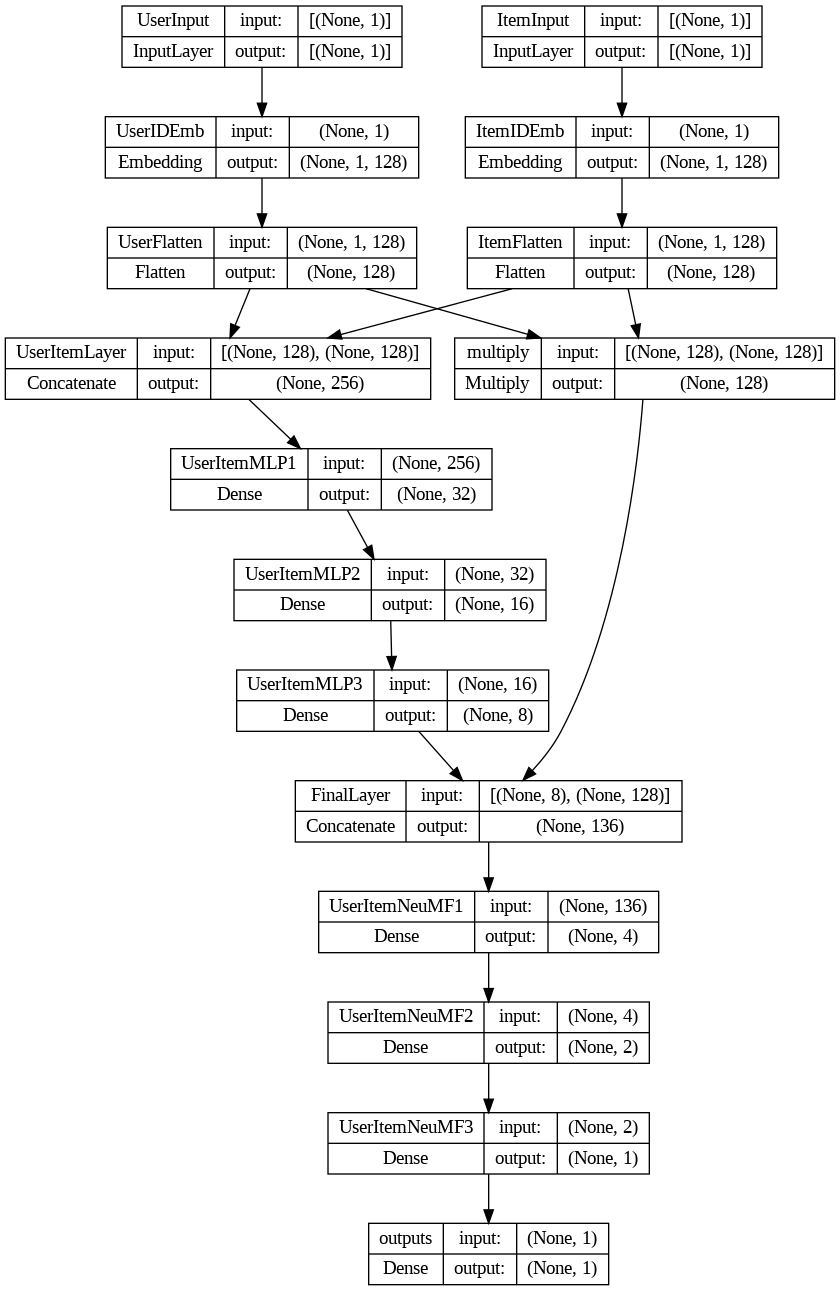

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)

# 파라미터 튜닝
- id_dim = [256, 128, 64]
- n layer = [2,3]
- layer_dim = [128, 64, 32]
- lr = [0.005, 0.001]

In [14]:
def model_run_param(id_dims, total_layer_dims,total_n_layer, lr):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID']],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID']],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID']])
    # normalize를 또할 필요가 없나?
    # prediction = 4 * norm(prediction) + 1
    prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    n_layer = total_n_layer
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},n_layer:{n_layer},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, n_layer, lr

In [15]:
user_num = 281335
item_num = 59044

id_dims = [256,128,64,32]
total_layer_dims = [128,64,32]
total_n_layer = [3]
lr = [0.001, 0.005]

In [16]:
MAE, RMSE, param_embedding, param_layer_dim, param_n_layer, param_lr = [], [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      for j in total_n_layer:
        MAE_temp, RMSE_temp, embedding_size, layer_dim, n_layer, learning_rate = model_run_param(a, b,j,i)

        MAE.append(MAE_temp)
        RMSE.append(RMSE_temp)
        param_embedding.append(embedding_size)
        param_layer_dim.append(layer_dim)
        param_n_layer.append(n_layer)
        param_lr.append(learning_rate)

Epoch 1/100
2199/2199 [==============================] - 43s 16ms/step - loss: 0.4317 - val_loss: 0.4124
Epoch 2/100
2199/2199 [==============================] - 18s 8ms/step - loss: 0.3796 - val_loss: 0.4130
Epoch 3/100
2199/2199 [==============================] - 18s 8ms/step - loss: 0.2967 - val_loss: 0.4520
Epoch 4/100
2199/2199 [==============================] - 18s 8ms/step - loss: 0.2451 - val_loss: 0.4640
Epoch 4: early stopping
20099/20099 [==============================] - 29s 1ms/step
embedding:256, layer_dim:128,n_layer:3,lr:0.001
MAE: 0.691
RMSE: 0.974
Epoch 1/100
2199/2199 [==============================] - 33s 13ms/step - loss: 0.4293 - val_loss: 0.4103
Epoch 2/100
2199/2199 [==============================] - 18s 8ms/step - loss: 0.3394 - val_loss: 0.4329
Epoch 3/100
2199/2199 [==============================] - 18s 8ms/step - loss: 0.2550 - val_loss: 0.4570
Epoch 4/100
2199/2199 [==============================] - 18s 8ms/step - loss: 0.2301 - val_loss: 0.4719
Epoch 4: ea

In [17]:
NeuMF_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_n_layer, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','N layer', 'Learning Rate','MAE','RMSE'])
NeuMF_df

,embedding size,layer_dim,N layer,Learning Rate,MAE,RMSE
0,256,128,3,0.001,0.691229,0.973790
1,256,128,3,0.005,0.692617,0.964946
2,256,64,3,0.001,0.663886,0.962293
3,256,64,3,0.005,0.700118,0.971844
4,256,32,3,0.001,0.927866,1.167453
5,256,32,3,0.005,0.927438,1.167455
6,128,128,3,0.001,0.691112,0.973468
7,128,128,3,0.005,0.697983,0.966144
8,128,64,3,0.001,0.669411,0.967540
9,128,64,3,0.005,0.704971,0.971875


In [18]:
# 저장
NeuMF_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-3.Final_NeuMF.csv",index=False)